In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense,Dropout
from keras import backend as K
import keras
import tensorflow as tf

# Load Data

In [2]:
files = glob.glob(r'data\*.csv')
files

['data\\gender_submission.csv', 'data\\test.csv', 'data\\train.csv']

In [3]:
df = pd.read_csv(files[2])

# Preprocessing

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
lower_col = [i.lower() for i in df.columns]
df.columns = lower_col

### Handle null items
#### I'll create some more variables from the original data and perform K-means Cluster to group them. Then replacing `age` null items with the median `age` of group they belong to. For `cabin`, I don't think it would be useful so I drop it instead. Finally, `embarked` would be done  by one hot .Any null values will replace by zero value.

In [7]:
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [8]:
df['Title'] = df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [9]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [10]:
df = pd.get_dummies(df, columns = ['sex','pclass','Title','embarked'], prefix = ['','class','','embarked'])

In [11]:
df.columns

Index(['passengerid', 'survived', 'name', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', '_female', '_male', 'class_1', 'class_2', 'class_3',
       '_Master', '_Miss', '_Mr', '_Mrs', '_Rare', 'embarked_C', 'embarked_Q',
       'embarked_S'],
      dtype='object')

In [12]:
df.drop(['passengerid','name','ticket','cabin'], axis =1, inplace = True ) # unuseful variables

#### k = 5 is optimal so 5 clusters accepted

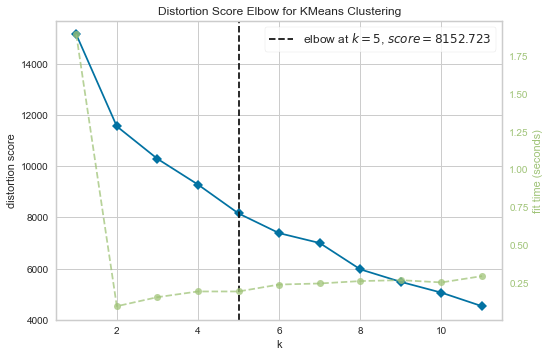

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
scaler = StandardScaler()
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (1,12))
visualizer.fit(scaler.fit_transform(df.select_dtypes(include = np.number).drop('age',axis =1)))
visualizer.show()


In [14]:
kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(scaler.fit_transform(df.select_dtypes(include = np.number).drop('age',axis =1)))


KMeans(n_clusters=5, random_state=42)

In [15]:
df['label'] = kmeans.labels_

<AxesSubplot:xlabel='label', ylabel='age'>

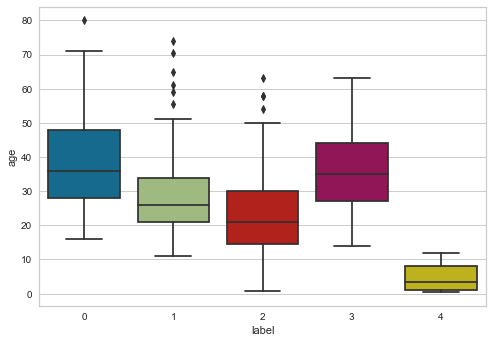

In [16]:
sns.boxplot(data = df, x = 'label', y = 'age')

In [17]:
for i in kmeans.labels_:
    df.loc[(df.label == i) & (df.age.isnull()) , 'age'] = df[df.label == i].age.median()

In [171]:
df.head()

,survived,age,sibsp,parch,fare,_female,_male,class_1,class_2,class_3,_Master,_Miss,_Mr,_Mrs,_Rare,embarked_C,embarked_Q,embarked_S,label
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,1,0,1,0,0,2
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,1,0,0,0,0,0,1,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,0,1,0,0,0,1,2
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0,0,1,0


# Machine learning

In [20]:
X_train = df.drop(['survived','label'], axis = 1).copy()
X_train = scaler.fit_transform(X_train)                       #Standard Scaling makes machine learning algorithm converge faster.
y_train = df.survived.copy()

In [22]:
X_train.shape

(891, 17)

#### Firstly, Stochastic Gradient Descent

In [24]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [25]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.5993266 , 0.75420875, 0.75084175])

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [27]:
confusion_matrix(y_train, y_train_pred)

array([[427, 122],
       [144, 198]], dtype=int64)

In [33]:
f1_score(y_train, y_train_pred) # SGD is not good enough

0.5981873111782479

#### Random Forrest

In [58]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
 method="predict_proba")

In [59]:
y_probas_forest

array([[0.81, 0.19],
       [0.  , 1.  ],
       [0.74, 0.26],
       ...,
       [0.68, 0.32],
       [0.75, 0.25],
       [0.37, 0.63]])

In [60]:
forest_pred = y_probas_forest[:,1]
forest_pred = np.round(forest_pred)

In [61]:
f1_score(y_train, forest_pred)

0.7310549777117384

RandomForrest has significantly outperformed SGD with 14% higher f1_score 

#### Small dataset => time to go GridSearch to fine tune the Random Forrest Classifier

In [109]:
param_grid = { 
    'n_estimators': range(400,601,10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [110]:
CV_rfc = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv= 5, n_jobs = -1, scoring='f1', verbose=3)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:  6.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(400, 601, 10)},
             scoring='f1', verbose=3)

In [111]:
cvres = CV_rfc.cv_results_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 400}

In [112]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 400}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 410}
0.7471142899763374 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 420}
0.7453011335363154 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 430}
0.7453011335363154 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 440}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 450}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 460}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 470}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 480}
0.7452459828448724 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', '

 When the hyperparameter dictionary is {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2'}, f1_score is highest and stable at 0.764. 
 Not very satisfied !

In [57]:
forest_clf.fit(X_train, y_train)
pd.DataFrame({'var': df.drop(['label','survived'], axis = 1).columns,
              'corr': forest_clf.feature_importances_}).sort_values('corr', ascending = False)

,var,corr
11,_Mr,0.204645
4,_female,0.184891
5,_male,0.165375
8,class_3,0.086120
3,fare,0.074832
10,_Miss,0.047682
6,class_1,0.044507
12,_Mrs,0.041239
0,age,0.040981
1,sibsp,0.036995


# Time for some deep things!

#### Create custom metric f1_score

In [329]:
def recall_m(y_true, y_pred):
    #y_pred = tf.math.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    #y_pred = tf.math.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    #y_pred = tf.math.round(y_pred)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### My neural Network

In [335]:
tf.keras.backend.clear_session()
classifier = Sequential()
classifier.add(Dense(activation="relu", input_dim=17, units=11, kernel_initializer="uniform"))
classifier.add(Dense(activation="relu", units=21, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=11, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=11, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=11, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=5, kernel_initializer="uniform"))
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = f1_m)
classifier.summary()

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
 restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                198       
_________________________________________________________________
dense_1 (Dense)              (None, 21)                252       
_________________________________________________________________
dropout (Dropout)            (None, 21)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                242       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_2 (Dropout)          (None, 11)                0

In [342]:
history=classifier.fit(X_train, y_train, batch_size = 10, epochs = 150,
    validation_split=0.1,shuffle=True, verbose = 1 ,callbacks = [lr_scheduler])

Epoch 1/150
81/81 [==============================] - 0s 2ms/step - loss: 0.5041 - f1_m: 0.7230 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 2/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5160 - f1_m: 0.7419 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 3/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5227 - f1_m: 0.7242 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 4/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5122 - f1_m: 0.7440 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 5/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5368 - f1_m: 0.7206 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 6/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5035 - f1_m: 0.7333 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 7/150
81/81 [==============================] - 0s 1ms/step - loss: 0.4947 - f1_m: 0.7241 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 8/150
81/81 [==============================] - 0s 1ms/step - lo

81/81 [==============================] - 0s 2ms/step - loss: 0.5094 - f1_m: 0.7313 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 124/150
81/81 [==============================] - 0s 1ms/step - loss: 0.4935 - f1_m: 0.7053 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 125/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5026 - f1_m: 0.7186 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 126/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5138 - f1_m: 0.6984 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 127/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5140 - f1_m: 0.7186 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 128/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5256 - f1_m: 0.7374 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 129/150
81/81 [==============================] - 0s 1ms/step - loss: 0.5098 - f1_m: 0.7191 - val_loss: 0.4181 - val_f1_m: 0.8290
Epoch 130/150
81/81 [==============================] - 0s 1ms/step - 

In [ ]:
classifier.save('my_model.h5')

In [222]:
new_model = load_model('my_model.h5', custom_objects={"f1_m": f1_m})

In [224]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                198       
_________________________________________________________________
dense_1 (Dense)              (None, 21)                252       
_________________________________________________________________
dropout (Dropout)            (None, 21)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                242       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_2 (Dropout)          (None, 11)                0

In [327]:
deep_pred = np.round(new_model.predict(X_train))
f1_score(y_train,deep_pred)

0.8117154811715482